In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("ac209b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 (209) - Clustering: GMM




**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas 


<hr style="height:2pt">

In [2]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

import seaborn as sns
import scipy as sp
from sklearn.datasets import make_spd_matrix

from matplotlib.patches import Ellipse

In [4]:
# Some matplotlib settings
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'x'
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['lines.markersize'] = 10

<a id="contents"></a>

# Generating Our Data

Here is the data we'll be modeling in this notebook.

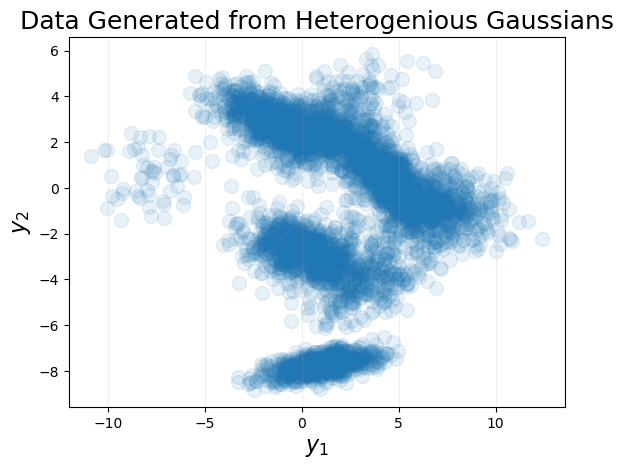

In [5]:
# data generation from random gaussians
N = 5_000
np.random.seed(2023)
K_true = np.random.choice(range(1,11), 1)[0]
pis_unnorm = np.random.uniform(0,1, size=K_true)
pis = pis_unnorm/pis_unnorm.sum()
mus = np.array([np.random.multivariate_normal(np.random.randn(2), 15*np.eye(2), size=1) for k in range(K_true)]).reshape(-1,2)
covs = np.array([make_spd_matrix(len(mus[0])) for k in range(K_true)])
zs = np.random.choice(np.arange(len(pis)), size=N, p=pis)
Y = np.array([np.random.multivariate_normal(mus[z], covs[z], 1)[0] for z in zs])
plt.scatter(*Y.T, alpha=0.1)
plt.title('Data Generated from Heterogenious Gaussians')
plt.xlabel('$y_1$')
plt.ylabel('$y_2$');

We could try KMeans for $k\in\{1,2,\dots,10\}$

In [6]:
kms = [KMeans(k, n_init=5).fit(Y) for k in range(1,11)]

And analyze our results.

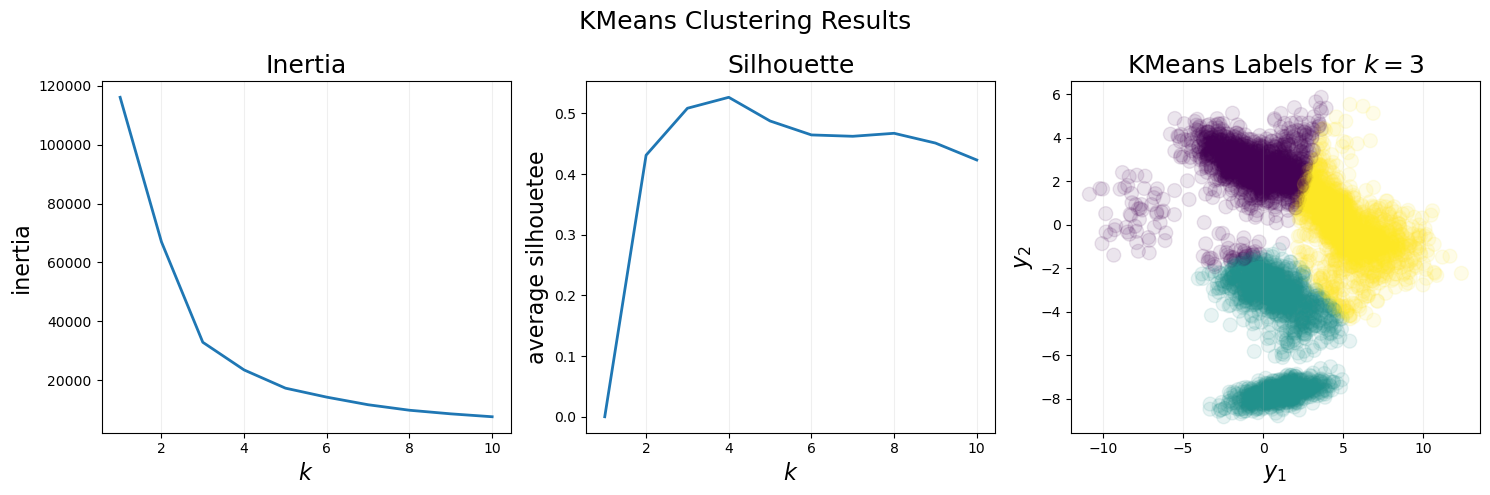

In [7]:
fix, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(range(1,11), [km.inertia_ for km in kms])
axs[0].set(xlabel='$k$', ylabel='inertia', title='Inertia')
axs[1].plot(range(1,11), [0]+[silhouette_score(Y, km.labels_) for km in kms[1:]])
axs[1].set(xlabel='$k$', ylabel='average silhouetee', title='Silhouette')
optimalk = 3
axs[2].scatter(*Y.T, alpha=0.1, c=kms[optimalk-1].labels_)
axs[2].set(xlabel='$y_1$', ylabel='$y_2$', title=f"KMeans Labels for $k={optimalk}$")
plt.suptitle('KMeans Clustering Results')
plt.tight_layout()

As a compromise between the inertia and the silhouette score we might select $k=3$ (there is a pretty clear elbow in the inertia here and it is *almost* the max silhouette).

However, the resulting clusters don't appear to fit the data well. Even if $k=3$ were the true number of Gaussians this doesn't seem to be the ideal way to assign the points. There's got to be a better way!

<a id="part1"></a>

## <div class='exercise'> Gaussian Mixture Models </div>

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**
    
In a ***Gaussian Mixture Model (GMM)***, we posit that the observed data $Y$ is generated by a mixture of $K$ of Gaussians each with their own set of parameters. For each observation $Y_n$ the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussian is responsible for generating $Y_n$:

We'll begin by modeling the data above with a mixture of **$k=3$ Gaussians**.
    
Write down a representation of this model, including all parameters and any latent variables.
    
**Note:** You should model the entire covariance matrix of each Gaussian

</div>

The observed data $Y$ is generated by a mixture of $K=3$ Gaussians with means $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \boldsymbol{\mu}_3$, and covariance matrices $\boldsymbol{\Sigma}_1, \boldsymbol{\Sigma}_2, \boldsymbol{\Sigma}_3$, respectively.

For each observation $Y_n$, the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussians is responsible for generating $Y_n$. $Z_n$ is a categorical variable that takes one of the values from the set ${1, 2, 3}$.
The mixture proportions $\boldsymbol{\pi} = {\pi_1, \pi_2, \pi_3}$ represent the probability of each Gaussian generating the data. These proportions must satisfy $\pi_k \geq 0$ and $\sum_{k=1}^{K} \pi_k = 1$.
Therefore, the complete set of parameters and latent variables for the GMM with $k=3$ Gaussians is:

- $\boldsymbol{\mu}_1$, $\boldsymbol{\mu}_2$, $\boldsymbol{\mu}_3$: The means of the three Gaussians.
- $\boldsymbol{\Sigma}_1$, $\boldsymbol{\Sigma}_2$, $\boldsymbol{\Sigma}_3$: The covariance matrices of the three Gaussians.
- $\boldsymbol{\pi} = {\pi_1, \pi_2, \pi_3}$: The mixture proportions.
- $Z_n$: The class of the observation $Y_n$.
- $Y_n$: The observed data.


Modeling the entire covariance matrix for each Gaussian is a more general approach than assuming diagonal covariance matrices, and it can capture complex dependencies between the features.

In this case, each Gaussian is characterized by a mean vector $\boldsymbol{\mu}_k$ and a covariance matrix $\boldsymbol{\Sigma}_k$. The covariance matrix $\boldsymbol{\Sigma}_k$ is a positive definite matrix with dimension $D \times D$, where $D$ is the number of features in the data.

The joint probability density function of the GMM can be written as:


$$p(\mathbf{Y},\mathbf{Z}|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma}) = \prod_{n=1}^{N}\prod_{k=1}^{K} \left[ \pi_k \mathcal{N}(\mathbf{Y}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}k) \right]^{Z_{nk}}$$	
 
 
where $\boldsymbol{\pi} = {\pi_1, \dots, \pi_K}$ are the mixing coefficients, $\boldsymbol{\mu} = {\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_K}$ are the means of the Gaussians, $\boldsymbol{\Sigma} = {\boldsymbol{\Sigma}_1, \dots, \boldsymbol{\Sigma}_K}$ are the covariance matrices of the Gaussians, and $\mathbf{Z}$ are the latent variables indicating the cluster assignments.

Each observation $\mathbf{Y}n$ is generated from one of the $K$ Gaussians, indicated by the corresponding $Z_{nk}$, which is a binary indicator variable that takes a value of 1 if the observation $\mathbf{Y}_n$ was generated by the $k$-th Gaussian, and 0 otherwise. The clustering assignment $\mathbf{Z}$ is therefore a binary matrix of size $N \times K$.

<div class='exercise-r'>

**1.2**
    
Now we'll start constructing the model in code.\
Initialize the parameters of your model. Call these variables `pi`, `mu`, `cov`.
    
Then plot the centers of your initialized distributions on top of a scatter plot data to see where we are starting from.

Some suggestions:
* The Guassian mixture weights, `pi`, should start out equal (i.e., data points are equally likely to be generated from any one of the Gaussians)
* Sample some of the data points to serve as the initial Gaussian centers. Just take care that you don't choose the same point more than once!
* SKLearn's `make_spd_matrix` can be used to genererate a symetric, positive semidefinite matricies (which are valid covariance matrices)

**Note:** here and else where cells have random seeds set at the top. Please try not to delete these as they help insure some degree of similarity across results.
</div>

In [8]:
# data generation from random gaussians
# N = 5_000
# np.random.seed(209)
# K_true = 3
# pis_unnorm = np.random.uniform(0,1, size=K_true)
# pis = pis_unnorm/pis_unnorm.sum()
# mus = np.array([np.random.multivariate_normal(np.random.randn(2), 
#                                               15*np.eye(2), size=1) for k in range(K_true)]).reshape(-1,2)
# covs = np.array([make_spd_matrix(len(mus[0])) for k in range(K_true)])
# zs = np.random.choice(np.arange(len(pis)), size=N, p=pis)
# Y = np.array([np.random.multivariate_normal(mus[z], covs[z], 1)[0] for z in zs])

# # Plot the initial Gaussian centers on top of the data
# fig, ax = plt.subplots()
# ax.scatter(Y[:, 0], Y[:, 1], s=50, cmap='viridis')

# colors = ['red', 'green', 'blue']
# for i, (m, c) in enumerate(zip(mu, cov)):
#     ellipse = Ellipse(xy=m, width=c[0, 0]*2, height=c[1, 1]*2,
#                       edgecolor=colors[i], fc='None', lw=2)
#     ax.add_patch(ellipse)

# plt.show()

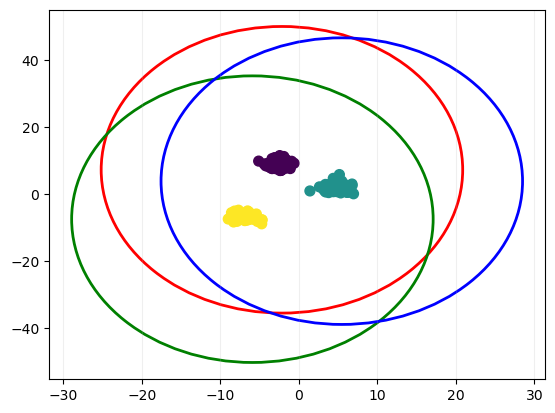

In [9]:
np.random.seed(209)
# your code here

# Initialize the parameters of the model
# data generation from random gaussians
# Initialize the parameters of the model
# Generate some sample data
X, y = make_blobs(n_samples=200, centers=3, random_state=42)

# Initialize the parameters of the model
n_components = 3
pi = np.full((n_components,), 1/n_components)
mu = X[np.random.choice(X.shape[0], n_components, replace=False)]
cov = np.array([np.diag(np.var(X, axis=0))] * n_components)

# Plot the initial Gaussian centers on top of the data
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

colors = ['red', 'green', 'blue']
for i, (m, c) in enumerate(zip(mu, cov)):
    ellipse = Ellipse(xy=m, width=c[0, 0]*2, height=c[1, 1]*2,
                      edgecolor=colors[i], fc='None', lw=2)
    ax.add_patch(ellipse)

plt.show()

# # Plot the initial Gaussian centers on top of the data
# fig, ax = plt.subplots()
# ax.scatter(Y[:, 0], Y[:, 1], s=10, alpha=0.5)


# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 
#           'yellow', 'orange', 'purple', 'pink', 'brown']
# for i, (m, c) in enumerate(zip(mu, cov)):
#     ellipse = Ellipse(xy=m, width=np.sqrt(c[0, 0])*2, height=np.sqrt(c[1, 1])*2,
#                       edgecolor=colors[i], fc='None', lw=2)
#     ax.add_patch(ellipse)
    
# plt.xlabel('Y1')
# plt.ylabel('Y2')
# plt.title('Centers of initialized distributions')

# plt.show()


In [10]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<div class='exercise-r'>

**1.3**
    
Use $\LaTeX$ to write out the calculations and parameter update rules for your model when performing the EM algorithm.
    
    
**Hint:** Consult the EM Algorithm described in the a-section slides and notebook.


</div>

1. Initialization step: Initialize the parameters of the model to some initial values.

2. Expectation Step: Compute the posterior distribution of the latent variables given the observed data and the current estimates of the parameters. This involves calculating the expected value of the log-likelihood function with respect to the posterior distribution of the latent variables.

$$Q(\theta | \theta^{(t)}) = E_{z|y,\theta^{(t)}} [ \log p(y, z | \theta)]$$

where $y$ is the observed data, $z$ is the latent variable, $\theta$ are the model parameters, and $\theta^{(t)}$ are the parameter estimates at iteration $t$.




3. Maximization Step: Maximize the expected log-likelihood function from the E step with respect to the parameters. This involves computing the partial derivatives of the expected log-likelihood function with respect to each of the parameters and setting them to zero to obtain the maximum likelihood estimates of the parameters.

Update the parameters $\pi_k$, $\boldsymbol{\mu}_k$, and $\boldsymbol{\Sigma}k$ to maximize $Q(\theta | \theta^{(t)})$. The update rules for the individual parameters are as follows:

$$\pi_k = \frac{\sum{n=1}^N r_{nk}}{N}$$
$$\boldsymbol{\mu}_k = \frac{\sum{n=1}^N r_{nk} y_n}{\sum_{n=1}^N r_{nk}}$$
$$\boldsymbol{\Sigma}_k = \frac{\sum{n=1}^N r_{nk} (y_n - \boldsymbol{\mu}_k)(y_n - \boldsymbol{\mu}_k)^T}{\sum{n=1}^N r_{nk}}$$

Where $r_{ik}$ is the responsibility of cluster $k$ for data point $i$, and $n$ is the number of data points:
$$r_{nk} = \frac{\pi_k \mathcal{N}(y_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum{j=1}^K \pi_j \mathcal{N}(y_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

Note that in the case of the spherical Gaussian mixture model, the covariance matrix $\boldsymbol{\Sigma}_k$ simplifies to a scalar value:

$$\boldsymbol{\Sigma}_k = \frac{\sum{n=1}^N r_{nk} (y_n - \boldsymbol{\mu}_k)^2}{\sum{n=1}^N r_{nk}}$$

<div class='exercise-r'>

**1.4**
    
Implement EM for 200 iterations. Updating your orginal parameters at each iterations.

Conclude by using the provided `plot_gaussians` function to visualize the mixture of Gaussians your model has converged to.
</div>

In [11]:
from scipy.stats import multivariate_normal

In [12]:
np.random.seed(209)
# your code here
K = 3
max_iter = 200
for i in range(max_iter):
    # E-step
    # your code here
    r = np.zeros((N, K))
    for k in range(K):
        r[:, k] = pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k])
    r_sum = np.sum(r, axis=1)
    r_sum[r_sum == 0] = 1e-16  # avoid divide by zero
    r = r / r_sum[:, None]
    # M-step
    N_k = np.sum(r, axis=0)
    pi = N_k / N
    mu = np.dot(r.T, Y) / N_k[:, None]
    for k in range(K):
        y_centered = Y - mu[k]
        cov[k] = np.dot((r[:, k] * y_centered.T), y_centered) / N_k[k]
    # your code here
    if i % 10 == 0:
        ll = np.sum(np.log(np.sum(pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k]) for k in range(K))))
        print(f"Iteration {i}: log-likelihood = {ll}")

/var/folders/bn/mhzy3bp10bl99gcw6tpnkhcc0000gn/T/ipykernel_13363/1950764203.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ll = np.sum(np.log(np.sum(pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k]) for k in range(K))))


Iteration 0: log-likelihood = -26007.243441989027
Iteration 10: log-likelihood = -24123.08696565394
Iteration 20: log-likelihood = -24094.300603654705
Iteration 30: log-likelihood = -24093.26078762643
Iteration 40: log-likelihood = -24092.906534622125
Iteration 50: log-likelihood = -24092.723818227634
Iteration 60: log-likelihood = -24092.598476787825
Iteration 70: log-likelihood = -24092.49039271248
Iteration 80: log-likelihood = -24092.37577081356
Iteration 90: log-likelihood = -24092.226154045515
Iteration 100: log-likelihood = -24091.980188343958
Iteration 110: log-likelihood = -24091.442945444673
Iteration 120: log-likelihood = -24089.716291529923
Iteration 130: log-likelihood = -24080.648445918247
Iteration 140: log-likelihood = -24043.7536663895
Iteration 150: log-likelihood = -24025.825885939154
Iteration 160: log-likelihood = -24024.844402320825
Iteration 170: log-likelihood = -24024.81713973392
Iteration 180: log-likelihood = -24024.81646213086
Iteration 190: log-likelihood =

In [13]:
def plot_gaussians(Y, pi, mu, cov):
    M = 200 # num grid points
    y1 = np.linspace(Y[:,0].min(), Y[:,0].max(), M)
    y2 = np.linspace(Y[:,1].min(), Y[:,1].max(), M)
    yy1, yy2 = np.meshgrid(y1,y2)
    YY = list(zip(yy1.flatten(), yy2.flatten()))
    
    plt.figure(figsize=(8,8))
    plt.scatter(yy1.flatten(), yy2.flatten())
    K = len(mu)
    for k in range(K):
        Z = sp.stats.multivariate_normal(mu[k], cov[k]).pdf(YY)
        plt.contour(yy1, yy2, pi[k]*Z.reshape(M,M), alpha=1)
    plt.scatter(*Y.T, alpha=0.5)
    plt.scatter(*mu.T)
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
    plt.title(f'GMM results for $k = {len(pi)}$')

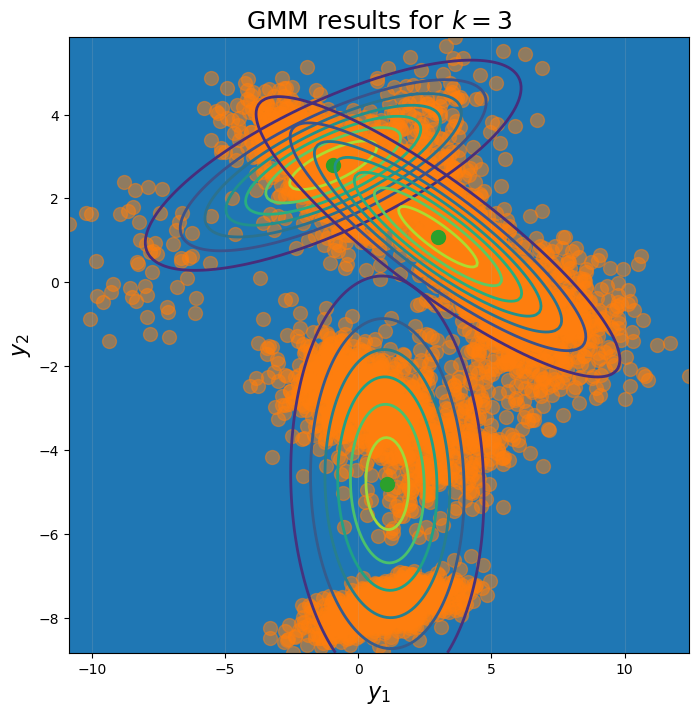

In [14]:
# your code here
plot_gaussians(Y, pi, mu, cov)

In [15]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<div class='exercise-r'>

**1.5** Write an expression showing how one could generate 'hard' cluster labels for data point $x_i$ based on the model parameters. By "cluster label" we mean a marker designating the Gaussian distribution that most likely generated a given data point.
    
</div>


For a given data point $x_i$, we can generate "hard" cluster labels by selecting the Gaussian distribution $k$ that maximizes the posterior probability of $z_i=k$ given $x_i$ and the current model parameters $\theta$:

$$\hat{z}_i = \operatorname*{argmax}{k} \frac{\pi_k N(x_i|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_i|\mu_j, \Sigma_j)}$$

Here, $\hat{z}_i$ is the selected cluster label for data point $x_i$, $\pi_k$ is the weight of the $k$-th Gaussian, $N(x_i|\mu_k, \Sigma_k)$ is the Gaussian probability density function with mean $\mu_k$ and covariance matrix $\Sigma_k$, and $K$ is the total number of Gaussian distributions in the mixture. The denominator in the expression represents the marginal likelihood of $x_i$ under the entire mixture model. The selected cluster label for $x_i$ is the index $k$ that maximizes the posterior probability.

<div class='exercise-r'>

**1.6**  Write down the model's log-likelihood function.
    
</div>


In the case of a Gaussian mixture model, the observed data is generated from a mixture of $K$ Gaussians, each with its own mean and covariance matrix. Each data point $y_n$ is assumed to have been generated by one of the $K$ Gaussians with some probability. The probability of a data point $y_n$ being generated by the $k$-th Gaussian is given by $\pi_k\mathcal{N}(y_n|\mu_k,\Sigma_k)$, where $\pi_k$ is the mixing coefficient for the $k$th Gaussian and $\mathcal{N}(y_n|\mu_k,\Sigma_k)$ is the probability density function of a multivariate Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$.

Therefore, the log-likelihood function for a Gaussian mixture model is the logarithm of the product of the probabilities of all the data points being generated by any of the $K$ Gaussians, summed over all possible Gaussians. This can be written as:

$$\ln \left(\prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(y_n|\mu_k,\Sigma_k) \right)$$

where $N$ is the number of data points.

<div class='exercise-r'>

**1.7**  For each $k \in \{1, 2, \dots, 10\}$, re-initialize all parameters and runs 200 iterations of the EM algorithm. Store each model's final average silhouette score and log likelihood in the lists `sil_scores` and `log_lkhd` respectively. We'll use these metrics to evaluate different choices of $k$.
    
**Hint:** You'll need cluster labels to calculated the silhouette score
</div>


In [16]:
np.random.seed(109)
# your code here
max_k = 10
sil_scores = []
log_lkhd = []

for K in range(1,max_k+1):
    # init params
    # your code here
    pis_unnorm = np.random.uniform(0, 1, size=K)
    pis = pis_unnorm / pis_unnorm.sum()
    mus = np.array([np.random.multivariate_normal(np.random.randn(2), 
                                                  15*np.eye(2), 
                                                  size=1) for j in range(K)]).reshape(-1, 2)
    covs = np.array([make_spd_matrix(len(mus[0])) for k in range(K)])
    
    for i in range(200):
        # E-step
        # your code here
        Qs = np.zeros((len(Y), K))
        for k in range(K):
            Qs[:, k] = pis[k] * multivariate_normal.pdf(Y, mean=mus[k], cov=covs[k])
        Qs = Qs / np.sum(Qs, axis=1)[:, np.newaxis]
        # M-step
        # your code here
        Ns = np.sum(Qs, axis=0)
        pis = Ns / len(Y)
        mus = np.dot(Qs.T, Y) / Ns[:, np.newaxis]
        for k in range(K):
            covs[k] = ((Y - mus[k]).T * Qs[:, k]).dot(Y - mus[k]) / Ns[k]
            covs[k] += 1e-6 * np.eye(len(mus[0]))
            
    # compute observed log-likelihood
    # your code here
    log_lkhd.append(np.log(np.sum(np.dot(Qs, pis))))
    
    # compute silhouette scores
    # your code here
    labels = np.argmax(Qs, axis=1)
    try:
        sil_scores.append(silhouette_score(Y, labels)) 
    # In the event of ValueError, set silhouette score to 0
    except ValueError:
        sil_scores.append(0)


In [17]:
grader.check("q1.7")

q1.7 results: All test cases passed!

<div class='exercise-r'>

**1.8**  

Because GMM is a probabalistic model, this opens up new possibilities for metrics.\
Read the brief section on [AIC & BIC](https://scikit-learn.org/stable/modules/linear_model.html#aic-bic) in the sci-kit learn documentation.

Next, create a pair of plots: one showing average silhouette score as a function of $k$ and the other showing both **AIC** and **BIC** as a function of $k$.
    
You will need to calculate the AIC and BIC metrics from the log likelihoods you stored above.
</div>

/var/folders/bn/mhzy3bp10bl99gcw6tpnkhcc0000gn/T/ipykernel_13363/1681883687.py:7: RuntimeWarning: divide by zero encountered in log
  aics = [n_samples * np.log(ssr) + 2 * k * n_features for k, ssr in zip(range(1, max_k + 1), sil_scores)]
/var/folders/bn/mhzy3bp10bl99gcw6tpnkhcc0000gn/T/ipykernel_13363/1681883687.py:8: RuntimeWarning: divide by zero encountered in log
  bics = [n_samples * np.log(ssr) + k * n_features * np.log(n_samples) for k, ssr in zip(range(1, max_k + 1), sil_scores)]


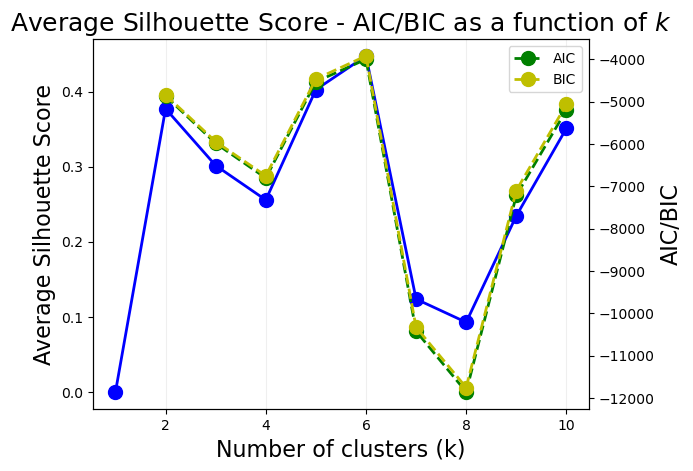

In [18]:
# your code here

avg_silhouette_scores = [np.mean(scores) for scores in sil_scores]

# Calculate AIC and BIC for each k
n_samples, n_features = Y.shape
aics = [n_samples * np.log(ssr) + 2 * k * n_features for k, ssr in zip(range(1, max_k + 1), sil_scores)]
bics = [n_samples * np.log(ssr) + k * n_features * np.log(n_samples) for k, ssr in zip(range(1, max_k + 1), sil_scores)]

# Plot average silhouette score vs k
fig, ax1 = plt.subplots()
plt.title('Average Silhouette Score - AIC/BIC as a function of $k$')
ax1.plot(range(1, max_k + 1), avg_silhouette_scores, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Average Silhouette Score')

# Plot AIC and BIC vs k
ax2 = ax1.twinx()
ax2.plot(range(1, max_k + 1), aics, 'go--')
ax2.plot(range(1, max_k + 1), bics, 'yo--')
ax2.set_ylabel('AIC/BIC')
ax2.legend(['AIC', 'BIC'])
plt.show()

In [19]:
# your code here
...

<div class='exercise-r'>

**1.9**  
    
Which value of $k$ is suggested by each of the 3 metrics? Are they in agreement? Do you trust in some of these metrics more than others? If so, explain why, supporting your poisition based on your understanding of the data, our clustering algorithm, and what the metrics reward and/or penalize. 

</div>

To choose a value of $k$ using the silhouette score, we select the number of clusters that maximizes the overall silhouette score. In this case, this is equivalent to $k=6$. 

AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are statistical measures used to compare different models, with lower values indicating better model fit. Hence, we need to choose the model with the lowest AIC or BIC value, which in this case is for $k=8$. 

<div class='exercise-r'>

**1.10** 
    
Now let's try scikit-learn's [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (imported as `GMM`).
    
Fit a series of GMMs with $k$ components for $k \in$ {1, 2, ..., 10} using  `random_state` 42 and `n_init=10`.
    
Next, compute each model's AIC and BIC and display them in a single plot how both AIC and BIC values change with the number of model components used.
    
Which value of $k$ is optimal according to each criterion?
    
*Note: You should also use `covariance_type="full"` and `init_params='random_from_data'` so it is similar to your from-scratch implementation above*

*Hint: Don't forget to consult the `GaussianMixture` documentation*

</div>

_Type your answer here, replacing this text._

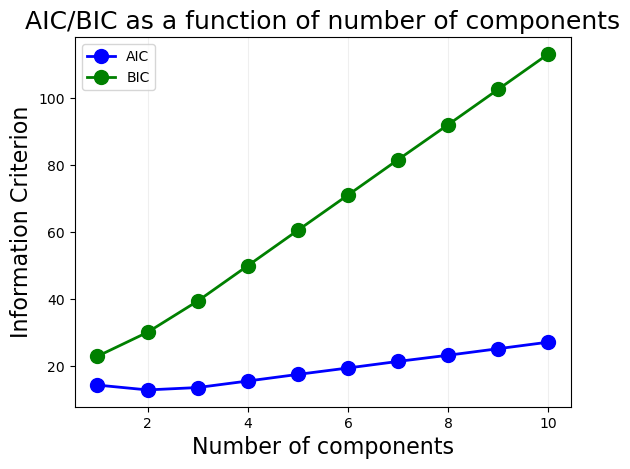

In [20]:
# your code here
# Fit a series of GMMs with k components
k_range = range(1, 11)
gmm_models = [GMM(n_components=k, random_state=42, n_init=10).fit(X) for k in k_range]

# Compute AIC and BIC for each model
n_samples, n_features = X.shape
log_likelihoods = [model.score(X) for model in gmm_models]
aics = [n_features * k - 2 * ll for k, ll in zip(k_range, log_likelihoods)]
bics = [n_features * k * np.log(n_samples) - 2 * ll for k, ll in zip(k_range, log_likelihoods)]

# Plot AIC and BIC values as a function of number of components
plt.title('AIC/BIC as a function of number of components')
plt.plot(k_range, aics, 'bo-', label='AIC')
plt.plot(k_range, bics, 'go-', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

<div class='exercise-r'>

**1.11** 
    
Use the metric plots to decide on a choice of $k$.
    
Then use `plot_gaussians` to visualize the GMM model fit with this choice of $k$ and a random state of `109`.
    
Compare your choice of $k$ with the variable `K_true`, the actual number of of Gaussians from which this data was generated. Do you think the GMM performed well at finding the underlying structure in the data? Name at least one very clear advantage SKLearn's implementation of GMM has over the your from-scratch implementation.

</div>

_Type your answer here, replacing this text._

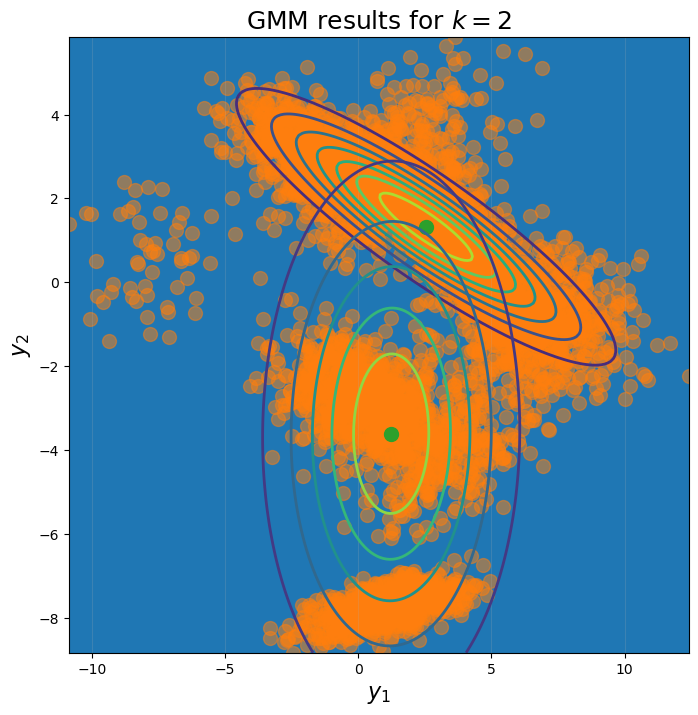

In [21]:
# your code here

best_k_GMM = GMM(n_components=2, random_state=42, n_init=10).fit(Y)

plot_gaussians(Y, best_k_GMM.weights_, best_k_GMM.means_, best_k_GMM.covariances_)

<div class='exercise-r'>

**1.12** 
    
Considering the differences between the two methods, describe at least 3 clear advantages the GMM approach has over KMeans when performing clustering.

</div>

_Type your answer here, replacing this text._

**This concludes HW1-209. Thank you!**